Créditos: Esse notebook é adaptado dos exemplos fornecidos pelo professor Eduardo Bezerra e códigos utilizados no T1.
- Link para o vídeo: XX

## Objetivo do trabalho:
* Apresentar implementações e descrevê-las com detalhes
* Apresentar os resultados
* Explicar em vídeo

# 1 Engenharia de Features

### Resumo:
* Classificação | 1500 exemplos | 11 atributos | credtrain.txt
* Preprocessamentos: ordinal + count enconding e normalização
* Mining: GradientBoostingClassifier

<s> Codificação Target </s>

Tentei utilizar codificação target, mas não gerou nada. A seguinte informação apareceu: "Warning: No categorical columns found. Calling 'transform' will only return input data."

## Seleção dos dados
Primeiramente é necessário baixar a base de dados

In [1]:
import pandas as pd
nome_colunas = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC', 'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']
data = pd.read_csv('cic1205/data/credtrain.txt', sep='\t', names=nome_colunas)

* O argumento **sep='\t'** detecta separações por tab
* O argumento **names=nome_colunas** foi utilizado para nomear as colunas. Para isso foi criada uma array com os nomes das colunas e passada para o parâmetro

## Preprocessamento
Agora tratarei os atributos categóricos e não categóricos.
* Categóricos: Serão codificados em novas variáveis usando ordinal e target encoding
* Não categóricos: Serão normalizados
* Ambos serão unidos num dataframe final

In [2]:
# Lista de variáveis categóricas
variaveis_categoricas = ['ESCT', 'NDEP', 'TIPOR', 'TEL']

# Lista de variáveis numéricas
variaveis_numericas = ['RENDA', 'VBEM', 'NPARC', 'VPARC', 'IDADE', 'RESMS', 'ENTRADA']

# Dataframe com variaveis categoricas
data_cat = data[variaveis_categoricas]

# Dataframe com variaveis numericas
data_num = data[variaveis_numericas]

### Normalização

In [3]:
from sklearn.preprocessing import MinMaxScaler  # Importando biblioteca de normalização Min-Max
scaler = MinMaxScaler()                         # Objeto que realiza a normalização
scaler.fit(data_num)                            # Ajustando o objeto aos dados

def normalizar(input_df):
    data_num_normalized = pd.DataFrame(             # Cria um dataframe que recebe como input um ndarray (numpy)
    scaler.transform(input_df), columns=input_df.columns # O nd-array é retornado pelo método transform
    )
    return data_num_normalized

data_num_normalized = normalizar(data_num)

### Codificação Ordinal

In [4]:
from sklearn.preprocessing import OrdinalEncoder

# Criando o objeto codificador ordinal
ordinal_encoder = OrdinalEncoder()

# Ajustando o objeto aos dados
ordinal_encoder.fit(data_cat)

# Função para codificar os dados usando Ordinal Encoding
def codificar_ordinal(input_df):
    nparray_encoded = ordinal_encoder.transform(input_df)
    data_cat_encoded = pd.DataFrame(nparray_encoded, columns=input_df.columns)
    return data_cat_encoded

# Codificando os dados
data_cat_encoded_ordinal = codificar_ordinal(data_cat)

### Codificação Contagem

Retornará quantas vezes um elemento aparece no dataset (pode ser útil para contar eventos etc)

In [5]:
from category_encoders import CountEncoder

# Criando o objeto codificador de contagem
count_encoder = CountEncoder()

# Ajustando o objeto aos dados
count_encoder.fit(data_cat)

# Codificando os dados
data_cat_encoded_count = count_encoder.transform(data_cat)

### Concatenando os dataframes preprocessados

In [6]:
data_preprocessed_ordinal = pd.concat( [ data_cat_encoded_ordinal, data_num_normalized, data['CLASSE'] ], axis=1 )

In [7]:
data_preprocessed_count = pd.concat( [ data_cat_encoded_count, data_num_normalized, data['CLASSE'] ], axis=1 )

## Mineração

O resultado de GradientBoosting com One-hot encoding **F1 Macro = 0.90**

### Usando Ordinal encoding com GradientBoosting

In [8]:
from sklearn.model_selection import train_test_split # Importa classe que faz amostragem (sampling)

X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed_ordinal.iloc[:,:-1], # features
                                                                data_preprocessed_ordinal.iloc[:,-1],  # labels
                                                                test_size=0.10,                 # % do test set (10%)
                                                                random_state=1)                # seed

In [9]:
from sklearn.ensemble import GradientBoostingClassifier  # Importando Classe de treinamento de Aumento de Gradiente
model = GradientBoostingClassifier(random_state=1)       # Instanciando objeto classificador
model.fit(X_train, y_train)                              # Ajustando o modelo

GradientBoostingClassifier(random_state=1)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")                            # Ajustando o modelo

Overfitted Accuracy: 94.07%


In [11]:
y_pred_validation = model.predict(X_validation) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.67%
Confusion Matrix:
 [[69  3]
 [14 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.96      0.82      0.88        78

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



#### Preprocessamento para teste do modelo
Como o dataset de teste está em outro arquivo (credtest.txt), será necessário repetir os passos de preprocessamento usando os objetos já treinados na fase de treinamento do modelo. Os passos são:
* Seleção de dados
* Separação dos atributos numéricos e categóricos
* Utilização dos objetos de preprocessamento já criados para transformar os novos dados (scaler e codificador)
* Junção do dataset
* Teste final

In [12]:
test_data = pd.read_csv('cic1205/data/credtest.txt', sep='\t', names=nome_colunas) # Seleção de dados
test_data_cat = test_data[variaveis_categoricas] # Separação dos atributos categóricos
test_data_num = test_data[variaveis_numericas]   # Separação dos atributos categóricos
test_data_cat_encoded = codificar_ordinal(test_data_cat)
test_data_num_normalized = normalizar(test_data_num)   # Normalização
test_data_preprocessed = pd.concat( [ test_data_cat_encoded, test_data_num_normalized, test_data['CLASSE'] ], axis=1 ) # Junção
X_test = test_data_preprocessed.iloc[:,:-1] # Conjuntos de dados
y_test = test_data_preprocessed.iloc[:,-1]  # Classificações

In [13]:
y_pred = model.predict(X_test) # Resultados no set de testes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.43%
Confusion Matrix:
 [[293  13]
 [ 48 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.94      0.82      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



### Usando Count encoding com GradientBoosting

In [14]:
from sklearn.model_selection import train_test_split # Importa classe que faz amostragem (sampling)

X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed_count.iloc[:,:-1], # features
                                                                data_preprocessed_count.iloc[:,-1],  # labels
                                                                test_size=0.10,                 # % do test set (10%)
                                                                random_state=1)                # seed

In [15]:
from sklearn.ensemble import GradientBoostingClassifier  # Importando Classe de treinamento de Aumento de Gradiente
model = GradientBoostingClassifier(random_state=1)       # Instanciando objeto classificador
model.fit(X_train, y_train)                              # Ajustando o modelo

GradientBoostingClassifier(random_state=1)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")                            # Ajustando o modelo

Overfitted Accuracy: 94.07%


In [17]:
y_pred_validation = model.predict(X_validation) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.67%
Confusion Matrix:
 [[69  3]
 [14 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.96      0.82      0.88        78

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



#### Preprocessamento para teste do modelo
Como o dataset de teste está em outro arquivo (credtest.txt), será necessário repetir os passos de preprocessamento usando os objetos já treinados na fase de treinamento do modelo. Os passos são:
* Seleção de dados
* Separação dos atributos numéricos e categóricos
* Utilização dos objetos de preprocessamento já criados para transformar os novos dados (scaler e codificador)
* Junção do dataset
* Teste final

In [18]:
test_data = pd.read_csv('cic1205/data/credtest.txt', sep='\t', names=nome_colunas) # Seleção de dados
test_data_cat = test_data[variaveis_categoricas] # Separação dos atributos categóricos
test_data_num = test_data[variaveis_numericas]   # Separação dos atributos categóricos
test_data_cat_encoded = count_encoder.transform(test_data_cat)
test_data_num_normalized = normalizar(test_data_num)   # Normalização
test_data_preprocessed = pd.concat( [ test_data_cat_encoded, test_data_num_normalized, test_data['CLASSE'] ], axis=1 ) # Junção
X_test = test_data_preprocessed.iloc[:,:-1] # Conjuntos de dados
y_test = test_data_preprocessed.iloc[:,-1]  # Classificações

In [19]:
y_pred = model.predict(X_test) # Resultados no set de testes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.43%
Confusion Matrix:
 [[293  13]
 [ 48 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.94      0.82      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



### Análise comparativa de resultados (F1-Macro avg):
- One-hot encoding: 0.90
- Ordinal encoding: 0.89
- Count encoding: 0.89

# 2 Validação Cruzada

### Resumo:
* Classificação | A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle
* Preprocessamentos: binarização
* Mining: GradientBoostingClassifier com CrossValidation
* Tarefa: Hyperparameter Tunning com Stritified5Fold Validation

In [20]:
import numpy as np
import pickle
fileA602 = open('cic1205/data/atmoseer/A602.pickle' , 'rb')
fileA621 = open('cic1205/data/atmoseer/A621.pickle' , 'rb')
fileA627 = open('cic1205/data/atmoseer/A627.pickle' , 'rb')
fileA636 = open('cic1205/data/atmoseer/A636.pickle' , 'rb')
fileA652 = open('cic1205/data/atmoseer/A652.pickle' , 'rb')

### Dataset A602

In [21]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA602)

In [22]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [23]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4, 6],
    'subsample': [0.3, 0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}


**Busca 1**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}

**Busca 2**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}

In [24]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.89%
Confusion Matrix:
 [[633  40]
 [ 45  47]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       673
         1.0       0.54      0.51      0.53        92

    accuracy                           0.89       765
   macro avg       0.74      0.73      0.73       765
weighted avg       0.89      0.89      0.89       765



#### Resultados A602
- F1 Classe 1 antigo: 0.54
- F1 Classe 1 novo: 0.53

### Dataset A621

In [25]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA621)

In [26]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [27]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4, 6],
    'subsample': [0.3, 0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}


**Busca 1**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}

**Busca 2**:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}

**Busca 3**: Mesmo que busca 2

In [28]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.24%
Confusion Matrix:
 [[8943  204]
 [ 477  456]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      9147
         1.0       0.69      0.49      0.57       933

    accuracy                           0.93     10080
   macro avg       0.82      0.73      0.77     10080
weighted avg       0.93      0.93      0.93     10080



#### Resultados A621
- F1 Classe 1 antigo: 0.58
- F1 Classe 1 novo: 0.57

### Dataset A627

In [29]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA627)

In [30]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [31]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'subsample': [0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}


**Best Hyperparameters**: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}

In [32]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.21%
Confusion Matrix:
 [[8902  298]
 [ 395  607]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      9200
         1.0       0.67      0.61      0.64      1002

    accuracy                           0.93     10202
   macro avg       0.81      0.79      0.80     10202
weighted avg       0.93      0.93      0.93     10202



#### Resultados A627
- F1 Classe 1 antigo: 0.62
- F1 Classe 1 novo: 0.63

### Dataset A636

In [33]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA636)

In [34]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [35]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'subsample': [0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}


**Best Hyperparameters**: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}

In [36]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 92.52%
Confusion Matrix:
 [[8832  185]
 [ 573  539]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9017
         1.0       0.74      0.48      0.59      1112

    accuracy                           0.93     10129
   macro avg       0.84      0.73      0.77     10129
weighted avg       0.92      0.93      0.92     10129



#### Resultados A636
- F1 Classe 1 antigo: 0.62
- F1 Classe 1 novo: 0.57

### Dataset A652

In [37]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA652)

In [38]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()

In [39]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'subsample': [0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Hora do treinamento
random_search.fit(X_train, y_train)

# Informar melhores parâmetros
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Setar um modelo com os melhores parâmetros
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}


**Best Hyperparameters**: {'subsample': 0.6, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.1}

In [40]:
# Predição
y_pred = best_model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.55%
Confusion Matrix:
 [[8711   58]
 [ 560  253]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.81      0.31      0.45       813

    accuracy                           0.94      9582
   macro avg       0.88      0.65      0.71      9582
weighted avg       0.93      0.94      0.92      9582



#### Resultados A652
- F1 Classe 1 antigo: 0.50
- F1 Classe 1 novo: 0.48

# 3 Classificação Multi-classes

### Resumo:
* Classificação | A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle
* Preprocessamentos: Discretização em 5 classes
* Mining: GradientBoostingClassifier com EarlyStopping

In [156]:
import numpy as np
import pickle
fileA602 = open('cic1205/data/atmoseer/A602.pickle' , 'rb')
fileA621 = open('cic1205/data/atmoseer/A621.pickle' , 'rb')
fileA627 = open('cic1205/data/atmoseer/A627.pickle' , 'rb')
fileA636 = open('cic1205/data/atmoseer/A636.pickle' , 'rb')
fileA652 = open('cic1205/data/atmoseer/A652.pickle' , 'rb')

### Dataset A602

In [157]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA602)

In [158]:
# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [159]:
%matplotlib inline 
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#Graphs
import matplotlib.pyplot as plt #visualization
from matplotlib import pyplot #visualization 

# fit model no training data
model1 = XGBClassifier(eval_metric=["merror", "mlogloss"])
eval_set = [(X_train, y_train), (X_val, y_val)]
model1.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.05050	validation_0-mlogloss:0.91707	validation_1-merror:0.11306	validation_1-mlogloss:0.95874
[1]	validation_0-merror:0.04903	validation_0-mlogloss:0.67194	validation_1-merror:0.10058	validation_1-mlogloss:0.73422
[2]	validation_0-merror:0.04873	validation_0-mlogloss:0.51688	validation_1-merror:0.10019	validation_1-mlogloss:0.59191
[3]	validation_0-merror:0.04755	validation_0-mlogloss:0.41207	validation_1-merror:0.09942	validation_1-mlogloss:0.49844
[4]	validation_0-merror:0.04588	validation_0-mlogloss:0.33892	validation_1-merror:0.09708	validation_1-mlogloss:0.43436
[5]	validation_0-merror:0.04421	validation_0-mlogloss:0.28645	validation_1-merror:0.09942	validation_1-mlogloss:0.38887
[6]	validation_0-merror:0.04274	validation_0-mlogloss:0.24724	validation_1-merror:0.09903	validation_1-mlogloss:0.35508
[7]	validation_0-merror:0.04107	validation_0-mlogloss:0.21858	validation_1-merror:0.10058	validation_1-mlogloss:0.33119
[8]	validation_0-merror:0.03979	validati

[68]	validation_0-merror:0.00953	validation_0-mlogloss:0.04314	validation_1-merror:0.10448	validation_1-mlogloss:0.26738
[69]	validation_0-merror:0.00835	validation_0-mlogloss:0.04166	validation_1-merror:0.10331	validation_1-mlogloss:0.26854
[70]	validation_0-merror:0.00806	validation_0-mlogloss:0.04064	validation_1-merror:0.10214	validation_1-mlogloss:0.27026
[71]	validation_0-merror:0.00815	validation_0-mlogloss:0.04016	validation_1-merror:0.10292	validation_1-mlogloss:0.26950
[72]	validation_0-merror:0.00786	validation_0-mlogloss:0.03952	validation_1-merror:0.10331	validation_1-mlogloss:0.26973
[73]	validation_0-merror:0.00747	validation_0-mlogloss:0.03897	validation_1-merror:0.10214	validation_1-mlogloss:0.26987
[74]	validation_0-merror:0.00698	validation_0-mlogloss:0.03840	validation_1-merror:0.10292	validation_1-mlogloss:0.27067
[75]	validation_0-merror:0.00678	validation_0-mlogloss:0.03763	validation_1-merror:0.10370	validation_1-mlogloss:0.27174
[76]	validation_0-merror:0.00668

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [160]:
# make predictions for test data
y_pred = model1.predict(X_test)

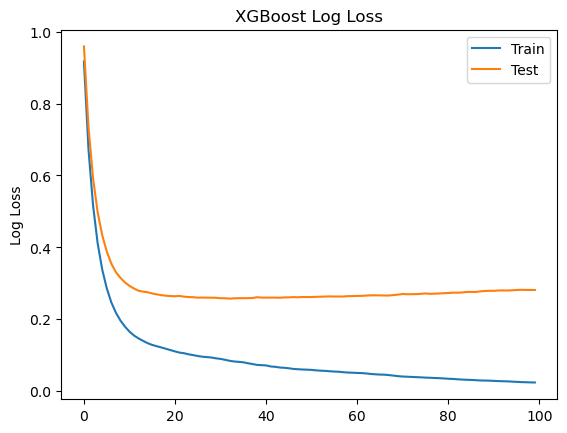

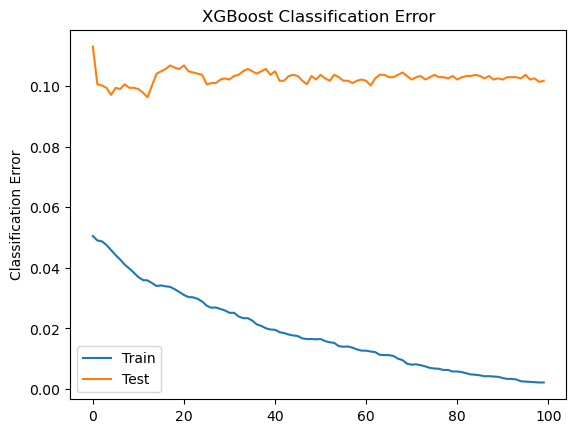

In [161]:
# retrieve performance metrics
results = model1.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

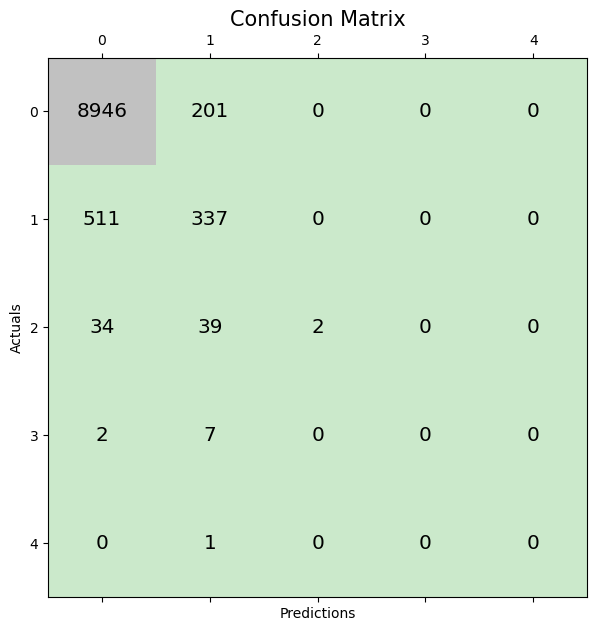

In [168]:
# Definindo a função de avaliação do modelo
def evaluate_model(y_test, y_pred, header):
    # make predictions for test data
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

    precision =  round(precision_score(y_test, y_pred, average='macro', zero_division=1), 4)
    recall = round(recall_score(y_test, y_pred, average='macro', zero_division=1), 4)
    F1 =  round(f1_score(y_test, y_pred, average='macro', zero_division=1), 4)
    metrics = [precision, recall, F1]

    results = pd.DataFrame(metrics)
    results.index = ['Precision', 'Recall', 'F1_score']
    results.columns = [header]
    results

evaluate_model(y_test, y_pred, 'With Early Stopping')

In [162]:
# Predição
y_pred = model1.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 86.67%
Confusion Matrix:
 [[631  40   2]
 [ 45  31   7]
 [  4   4   1]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       673
         1.0       0.41      0.37      0.39        83
         2.0       0.10      0.11      0.11         9

    accuracy                           0.87       765
   macro avg       0.48      0.47      0.48       765
weighted avg       0.86      0.87      0.86       765



#### Resultados A602
- F1 Classe 1 antigo: 0.54
- F1 Classe 1 novo: 0.53
- F1 Classes 1 e 2: 0.46 e 0.31

### Dataset A621

In [163]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA621)

In [164]:
# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [165]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot

# fit model no training data
model2 = XGBClassifier(eval_metric=["merror", "mlogloss"])
eval_set = [(X_train, y_train), (X_val, y_val)]
model2.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model2.predict(X_test)

[0]	validation_0-merror:0.04817	validation_0-mlogloss:0.91535	validation_1-merror:0.07166	validation_1-mlogloss:0.93473
[1]	validation_0-merror:0.04639	validation_0-mlogloss:0.66818	validation_1-merror:0.07290	validation_1-mlogloss:0.70043
[2]	validation_0-merror:0.04524	validation_0-mlogloss:0.51178	validation_1-merror:0.07249	validation_1-mlogloss:0.55235
[3]	validation_0-merror:0.04315	validation_0-mlogloss:0.40583	validation_1-merror:0.07125	validation_1-mlogloss:0.45322
[4]	validation_0-merror:0.04189	validation_0-mlogloss:0.33175	validation_1-merror:0.07002	validation_1-mlogloss:0.38482
[5]	validation_0-merror:0.04084	validation_0-mlogloss:0.27829	validation_1-merror:0.07084	validation_1-mlogloss:0.33886
[6]	validation_0-merror:0.03927	validation_0-mlogloss:0.23902	validation_1-merror:0.06960	validation_1-mlogloss:0.30563
[7]	validation_0-merror:0.03864	validation_0-mlogloss:0.20986	validation_1-merror:0.07125	validation_1-mlogloss:0.28135
[8]	validation_0-merror:0.03781	validati

[68]	validation_0-merror:0.00524	validation_0-mlogloss:0.03168	validation_1-merror:0.07867	validation_1-mlogloss:0.23164
[69]	validation_0-merror:0.00524	validation_0-mlogloss:0.03136	validation_1-merror:0.07743	validation_1-mlogloss:0.23249
[70]	validation_0-merror:0.00524	validation_0-mlogloss:0.03118	validation_1-merror:0.07784	validation_1-mlogloss:0.23274
[71]	validation_0-merror:0.00524	validation_0-mlogloss:0.03091	validation_1-merror:0.07825	validation_1-mlogloss:0.23271
[72]	validation_0-merror:0.00503	validation_0-mlogloss:0.03050	validation_1-merror:0.07661	validation_1-mlogloss:0.23335
[73]	validation_0-merror:0.00482	validation_0-mlogloss:0.03006	validation_1-merror:0.07743	validation_1-mlogloss:0.23403
[74]	validation_0-merror:0.00429	validation_0-mlogloss:0.02886	validation_1-merror:0.07784	validation_1-mlogloss:0.23462
[75]	validation_0-merror:0.00408	validation_0-mlogloss:0.02778	validation_1-merror:0.07702	validation_1-mlogloss:0.23435
[76]	validation_0-merror:0.00387

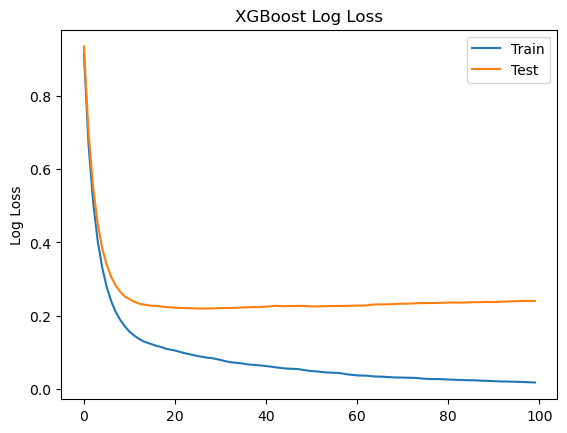

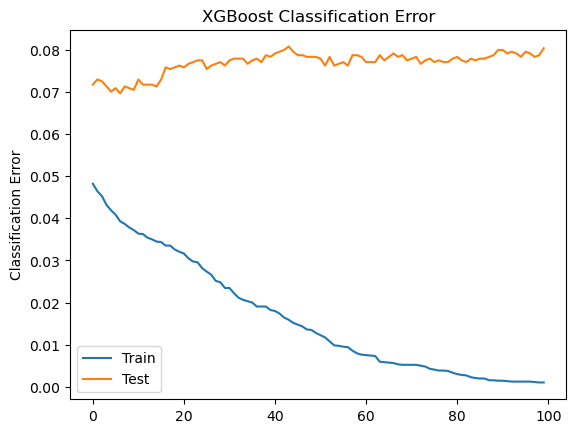

In [166]:
# retrieve performance metrics
results = model2.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

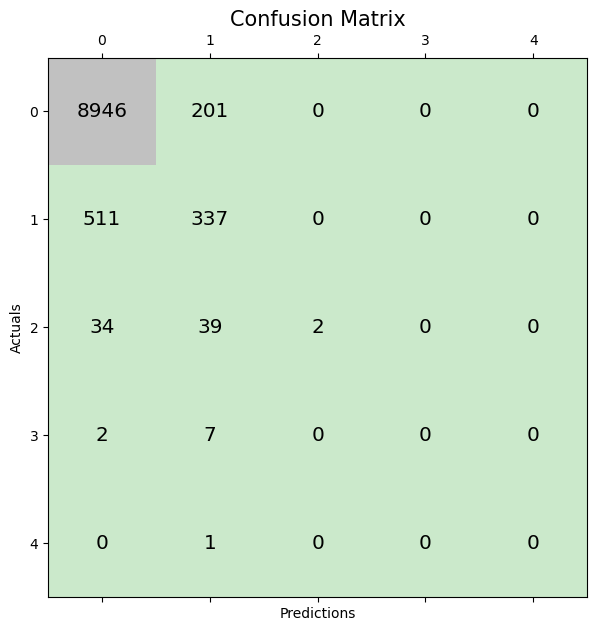

In [169]:
evaluate_model(y_test, y_pred, 'With Early Stopping')

In [170]:
# Predição
y_pred = model2.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 92.11%
Confusion Matrix:
 [[8946  201    0    0    0]
 [ 511  337    0    0    0]
 [  34   39    2    0    0]
 [   2    7    0    0    0]
 [   0    1    0    0    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9147
         1.0       0.58      0.40      0.47       848
         2.0       1.00      0.03      0.05        75
         3.0       1.00      0.00      0.00         9
         4.0       1.00      0.00      0.00         1

    accuracy                           0.92     10080
   macro avg       0.90      0.28      0.30     10080
weighted avg       0.91      0.92      0.91     10080



#### Resultados A621
- F1 Classe 1 antigo: 0.54
- F1 Classe 1 novo: 0.53
- F1 Classes 1, 2, 3, 4: 0.47, 0.05, 0.00 e 0.00

### Dataset A627

In [171]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA627)

In [172]:
# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [173]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot

# fit model no training data
model3 = XGBClassifier(eval_metric=["merror", "mlogloss"])
eval_set = [(X_train, y_train), (X_val, y_val)]
model3.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model3.predict(X_test)

[0]	validation_0-merror:0.05030	validation_0-mlogloss:1.01660	validation_1-merror:0.10157	validation_1-mlogloss:1.07181
[1]	validation_0-merror:0.04978	validation_0-mlogloss:0.73702	validation_1-merror:0.10694	validation_1-mlogloss:0.84807
[2]	validation_0-merror:0.04761	validation_0-mlogloss:0.56166	validation_1-merror:0.10246	validation_1-mlogloss:0.68670
[3]	validation_0-merror:0.04596	validation_0-mlogloss:0.44230	validation_1-merror:0.10112	validation_1-mlogloss:0.56853
[4]	validation_0-merror:0.04400	validation_0-mlogloss:0.35841	validation_1-merror:0.09709	validation_1-mlogloss:0.49290
[5]	validation_0-merror:0.04080	validation_0-mlogloss:0.29788	validation_1-merror:0.09351	validation_1-mlogloss:0.43958
[6]	validation_0-merror:0.03904	validation_0-mlogloss:0.25257	validation_1-merror:0.09530	validation_1-mlogloss:0.39859
[7]	validation_0-merror:0.03842	validation_0-mlogloss:0.21880	validation_1-merror:0.09262	validation_1-mlogloss:0.36642
[8]	validation_0-merror:0.03646	validati

[68]	validation_0-merror:0.00403	validation_0-mlogloss:0.03121	validation_1-merror:0.09709	validation_1-mlogloss:0.27780
[69]	validation_0-merror:0.00403	validation_0-mlogloss:0.03027	validation_1-merror:0.09530	validation_1-mlogloss:0.27869
[70]	validation_0-merror:0.00392	validation_0-mlogloss:0.02950	validation_1-merror:0.09575	validation_1-mlogloss:0.27886
[71]	validation_0-merror:0.00320	validation_0-mlogloss:0.02862	validation_1-merror:0.09620	validation_1-mlogloss:0.27908
[72]	validation_0-merror:0.00258	validation_0-mlogloss:0.02793	validation_1-merror:0.09530	validation_1-mlogloss:0.27917
[73]	validation_0-merror:0.00279	validation_0-mlogloss:0.02736	validation_1-merror:0.09620	validation_1-mlogloss:0.28004
[74]	validation_0-merror:0.00248	validation_0-mlogloss:0.02678	validation_1-merror:0.09620	validation_1-mlogloss:0.27821
[75]	validation_0-merror:0.00258	validation_0-mlogloss:0.02615	validation_1-merror:0.09620	validation_1-mlogloss:0.27767
[76]	validation_0-merror:0.00238

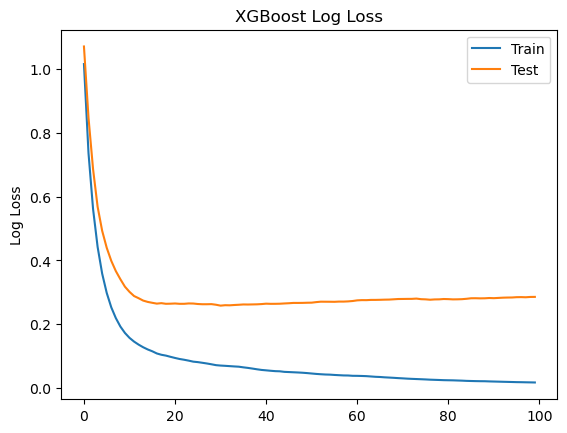

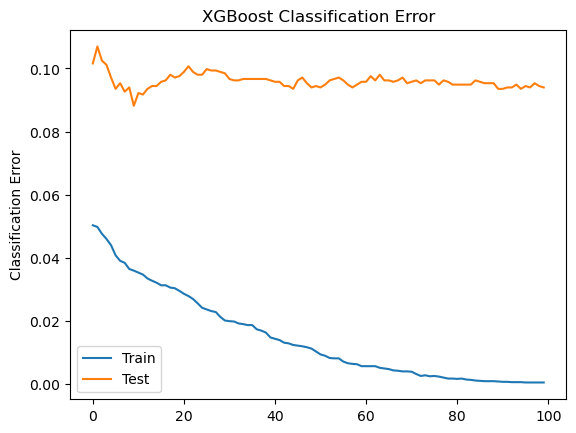

In [174]:
# retrieve performance metrics
results = model3.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

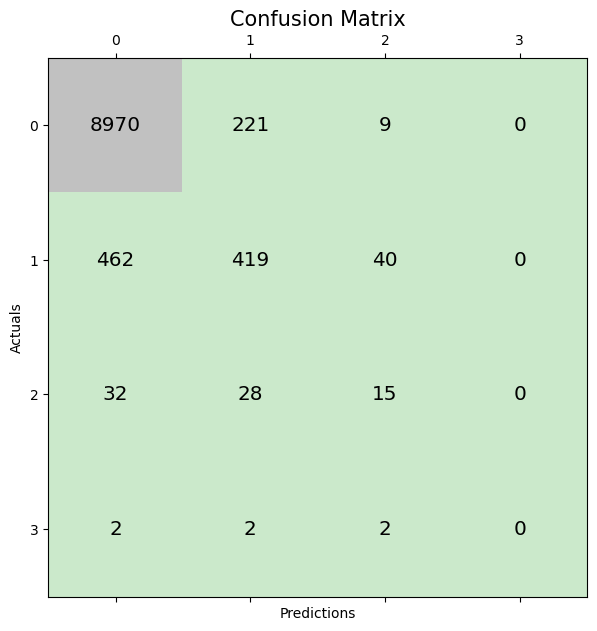

In [175]:
evaluate_model(y_test, y_pred, 'With Early Stopping')

In [176]:
# Predição
y_pred = model3.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 92.18%
Confusion Matrix:
 [[8970  221    9    0]
 [ 462  419   40    0]
 [  32   28   15    0]
 [   2    2    2    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      9200
         1.0       0.63      0.45      0.53       921
         2.0       0.23      0.20      0.21        75
         3.0       1.00      0.00      0.00         6

    accuracy                           0.92     10202
   macro avg       0.70      0.41      0.43     10202
weighted avg       0.91      0.92      0.92     10202



#### Resultados A627
- F1 Classe 1 antigo: 0.62
- F1 Classe 1 novo: 0.63
- F1 Classe 1,2 e 3: 0.53, 0.21 e 0

### Dataset A636

In [177]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA636)

In [178]:
# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [179]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot

# fit model no training data
model4 = XGBClassifier(eval_metric=["merror", "mlogloss"])
eval_set = [(X_train, y_train), (X_val, y_val)]
model4.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model4.predict(X_test)

[0]	validation_0-merror:0.05441	validation_0-mlogloss:0.92034	validation_1-merror:0.07291	validation_1-mlogloss:0.93202
[1]	validation_0-merror:0.05314	validation_0-mlogloss:0.67730	validation_1-merror:0.07125	validation_1-mlogloss:0.69785
[2]	validation_0-merror:0.05147	validation_0-mlogloss:0.52287	validation_1-merror:0.07498	validation_1-mlogloss:0.54969
[3]	validation_0-merror:0.04961	validation_0-mlogloss:0.41908	validation_1-merror:0.07622	validation_1-mlogloss:0.45196
[4]	validation_0-merror:0.04883	validation_0-mlogloss:0.34628	validation_1-merror:0.07332	validation_1-mlogloss:0.38546
[5]	validation_0-merror:0.04805	validation_0-mlogloss:0.29425	validation_1-merror:0.07291	validation_1-mlogloss:0.33894
[6]	validation_0-merror:0.04717	validation_0-mlogloss:0.25690	validation_1-merror:0.07332	validation_1-mlogloss:0.30536
[7]	validation_0-merror:0.04580	validation_0-mlogloss:0.22940	validation_1-merror:0.07374	validation_1-mlogloss:0.28196
[8]	validation_0-merror:0.04501	validati

[68]	validation_0-merror:0.00851	validation_0-mlogloss:0.04348	validation_1-merror:0.07125	validation_1-mlogloss:0.23733
[69]	validation_0-merror:0.00832	validation_0-mlogloss:0.04270	validation_1-merror:0.07084	validation_1-mlogloss:0.23803
[70]	validation_0-merror:0.00793	validation_0-mlogloss:0.04156	validation_1-merror:0.07125	validation_1-mlogloss:0.23937
[71]	validation_0-merror:0.00753	validation_0-mlogloss:0.04090	validation_1-merror:0.07042	validation_1-mlogloss:0.23913
[72]	validation_0-merror:0.00744	validation_0-mlogloss:0.04075	validation_1-merror:0.07042	validation_1-mlogloss:0.23948
[73]	validation_0-merror:0.00744	validation_0-mlogloss:0.03982	validation_1-merror:0.07042	validation_1-mlogloss:0.23989
[74]	validation_0-merror:0.00695	validation_0-mlogloss:0.03885	validation_1-merror:0.07125	validation_1-mlogloss:0.24115
[75]	validation_0-merror:0.00685	validation_0-mlogloss:0.03845	validation_1-merror:0.07125	validation_1-mlogloss:0.24142
[76]	validation_0-merror:0.00675

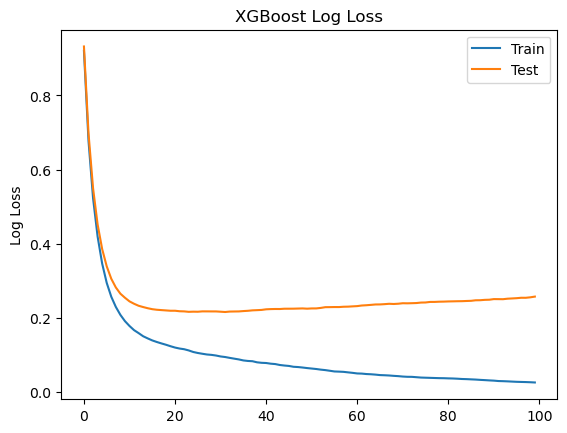

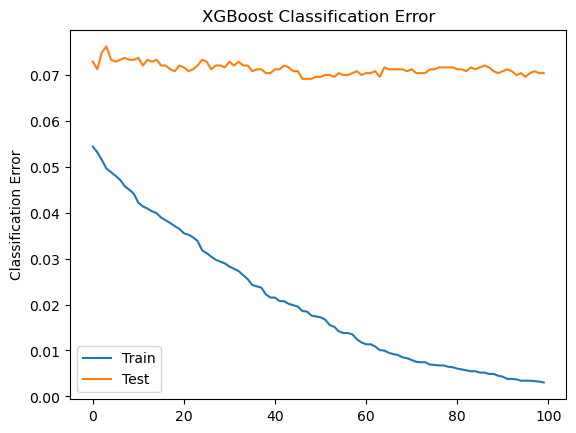

In [181]:
# retrieve performance metrics
results = model4.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

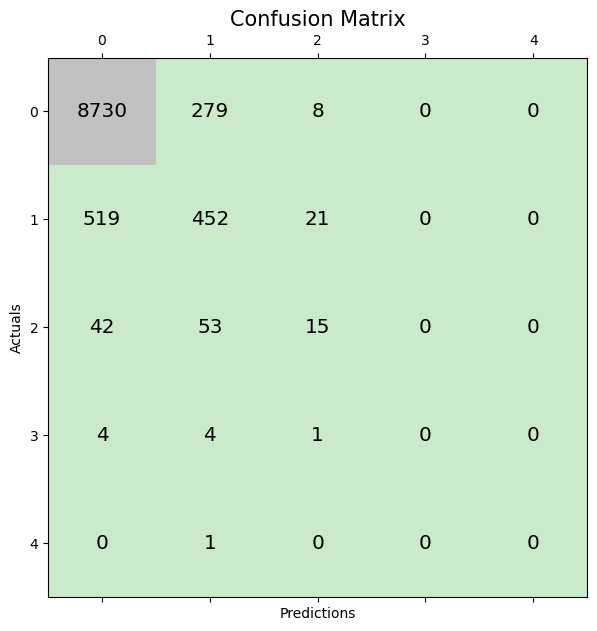

In [182]:
evaluate_model(y_test, y_pred, 'With Early Stopping')

In [183]:
# Predição
y_pred = model4.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 90.80%
Confusion Matrix:
 [[8730  279    8    0    0]
 [ 519  452   21    0    0]
 [  42   53   15    0    0]
 [   4    4    1    0    0]
 [   0    1    0    0    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      9017
         1.0       0.57      0.46      0.51       992
         2.0       0.33      0.14      0.19       110
         3.0       1.00      0.00      0.00         9
         4.0       1.00      0.00      0.00         1

    accuracy                           0.91     10129
   macro avg       0.77      0.31      0.33     10129
weighted avg       0.90      0.91      0.90     10129



#### Resultados A636
- F1 Classe 1 antigo: 0.62
- F1 Classe 1 novo: 0.57
- F1 Classe 1,2,3,4: 0.51, 0.19, 0 e 0

### Dataset A652

In [184]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA652)

In [185]:
# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [186]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot

# fit model no training data
model5 = XGBClassifier(eval_metric=["merror", "mlogloss"])
eval_set = [(X_train, y_train), (X_val, y_val)]
model5.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model5.predict(X_test)

[0]	validation_0-merror:0.04335	validation_0-mlogloss:0.90717	validation_1-merror:0.06385	validation_1-mlogloss:0.92281
[1]	validation_0-merror:0.04055	validation_0-mlogloss:0.65691	validation_1-merror:0.06544	validation_1-mlogloss:0.68614
[2]	validation_0-merror:0.03795	validation_0-mlogloss:0.49783	validation_1-merror:0.06345	validation_1-mlogloss:0.53463
[3]	validation_0-merror:0.03626	validation_0-mlogloss:0.38981	validation_1-merror:0.06425	validation_1-mlogloss:0.43522
[4]	validation_0-merror:0.03436	validation_0-mlogloss:0.31422	validation_1-merror:0.06425	validation_1-mlogloss:0.36457
[5]	validation_0-merror:0.03286	validation_0-mlogloss:0.25939	validation_1-merror:0.06265	validation_1-mlogloss:0.31513
[6]	validation_0-merror:0.03226	validation_0-mlogloss:0.21969	validation_1-merror:0.06425	validation_1-mlogloss:0.27891
[7]	validation_0-merror:0.03126	validation_0-mlogloss:0.19003	validation_1-merror:0.06345	validation_1-mlogloss:0.25305
[8]	validation_0-merror:0.03016	validati

[68]	validation_0-merror:0.00330	validation_0-mlogloss:0.02396	validation_1-merror:0.07422	validation_1-mlogloss:0.23103
[69]	validation_0-merror:0.00260	validation_0-mlogloss:0.02324	validation_1-merror:0.07422	validation_1-mlogloss:0.23150
[70]	validation_0-merror:0.00230	validation_0-mlogloss:0.02263	validation_1-merror:0.07462	validation_1-mlogloss:0.23103
[71]	validation_0-merror:0.00230	validation_0-mlogloss:0.02225	validation_1-merror:0.07462	validation_1-mlogloss:0.23161
[72]	validation_0-merror:0.00210	validation_0-mlogloss:0.02177	validation_1-merror:0.07462	validation_1-mlogloss:0.23242
[73]	validation_0-merror:0.00190	validation_0-mlogloss:0.02132	validation_1-merror:0.07462	validation_1-mlogloss:0.23273
[74]	validation_0-merror:0.00180	validation_0-mlogloss:0.02114	validation_1-merror:0.07502	validation_1-mlogloss:0.23390
[75]	validation_0-merror:0.00180	validation_0-mlogloss:0.02091	validation_1-merror:0.07422	validation_1-mlogloss:0.23395
[76]	validation_0-merror:0.00130

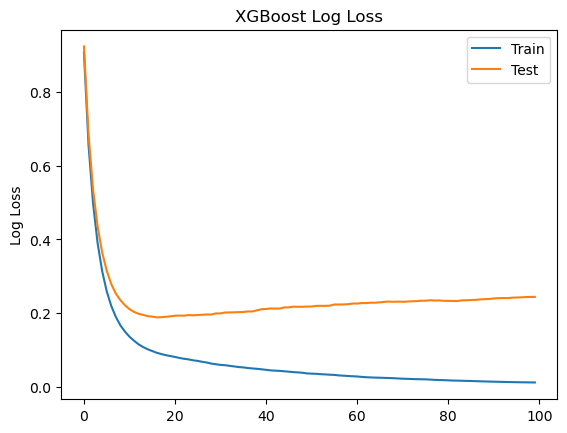

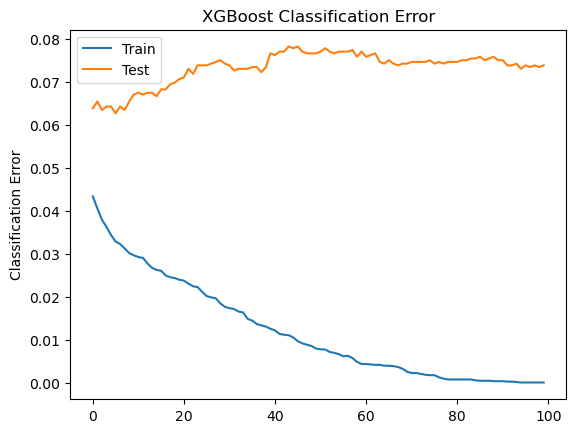

In [187]:
# retrieve performance metrics
results = model5.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

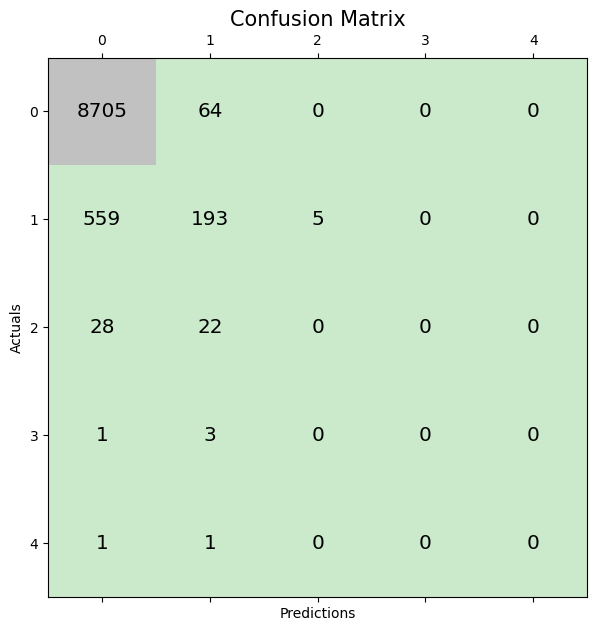

In [188]:
evaluate_model(y_test, y_pred, 'With Early Stopping')

In [189]:
# Predição
y_pred = model5.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 92.86%
Confusion Matrix:
 [[8705   64    0    0    0]
 [ 559  193    5    0    0]
 [  28   22    0    0    0]
 [   1    3    0    0    0]
 [   1    1    0    0    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      8769
         1.0       0.68      0.25      0.37       757
         2.0       0.00      0.00      1.00        50
         3.0       1.00      0.00      0.00         4
         4.0       1.00      0.00      0.00         2

    accuracy                           0.93      9582
   macro avg       0.72      0.25      0.47      9582
weighted avg       0.91      0.93      0.92      9582



#### Resultados A652
- F1 Classe 1 antigo: 0.50
- F1 Classe 1 novo: 0.48
- F1 Classe 1,2,3,4: 0.37, 1, 0 e 0

### Conclusões:
- Uso de uma classe única parece ser mais adequado para aumentar a taxa de acerto do modelo.

# 4 SHAP Values

### Resumo:
* Utilizar shap values para explicar os modelos do exercício 3
 - a)Qual a importância de cada feature para uma predição específica?
 - b)Como uma feature específica impacta a predição em geral?
 - c)Como cada feature contribui para o desempenho do modelo?
 - d)Quais instâncias da classe EXTREME são as mais influenciadas por uma determinada feature?
 - e)Quais features têm contribuições consistentes ou inconsistentes em instância classe EXTREME?
 - f)Como as predições mudam com variações nas features?
 - g)Quais features estão mais correlacionadas com outras em termos de contribuição para as predições?

In [152]:
# Pegando os nomes das colunas
gzip_file_path = 'cic1205/data/atmoseer/A621_test.parquet.gzip'
df = pd.read_parquet(gzip_file_path)
# Ajustando as colunas
column_names = df.columns
repeated_columns = np.repeat(column_names, 3) #column_names do arquivo 
nomes_das_colunas = df[repeated_columns].columns
print(nomes_das_colunas)

Index(['temperature', 'temperature', 'temperature', 'barometric_pressure',
       'barometric_pressure', 'barometric_pressure', 'relative_humidity',
       'relative_humidity', 'relative_humidity', 'wind_direction_u',
       'wind_direction_u', 'wind_direction_u', 'wind_direction_v',
       'wind_direction_v', 'wind_direction_v', 'hour_sin', 'hour_sin',
       'hour_sin', 'hour_cos', 'hour_cos', 'hour_cos', 'precipitation',
       'precipitation', 'precipitation'],
      dtype='object')


In [154]:
import shap
shap.initjs()

Os modelos estão salvos nos objetos model1, model2, model3, model4 e model5.

### Explicando o modelo 1

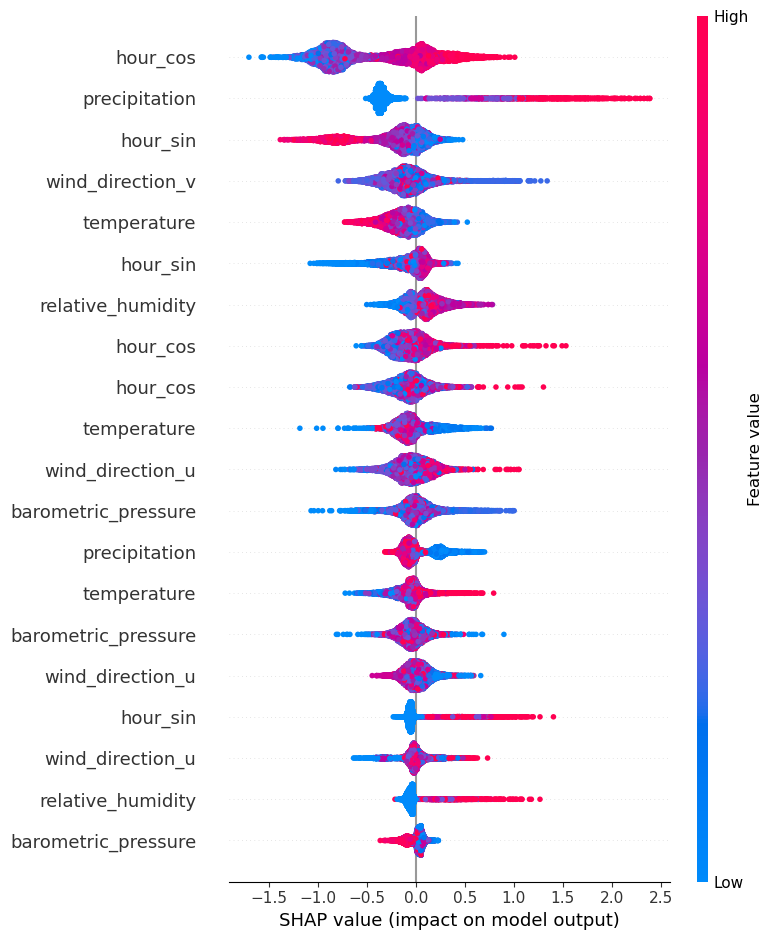

In [193]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test)
# Resumo
shap.summary_plot(shap_values[1], X_test, feature_names=nomes_das_colunas)

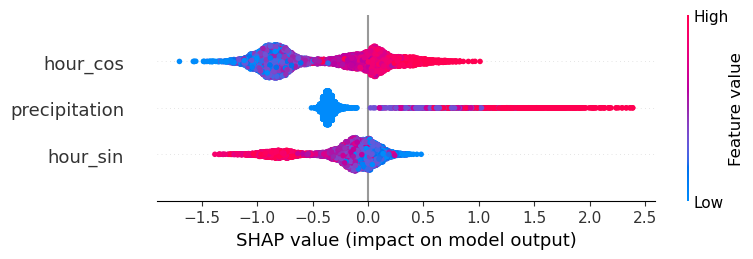

In [197]:
# Features mais importantes
shap.summary_plot(shap_values[1], X_test, max_display=3, feature_names=nomes_das_colunas)

**Questão b**. Aqui podemos ver as principais features que afetam o modelo.
- Hour_cos afeta muito o modelo tanto com valores altos quanto baixos
- Precipitation afeta o modelo quanto possui valores altos
- Hour_sin afeta o modelo quando possui valores baixos

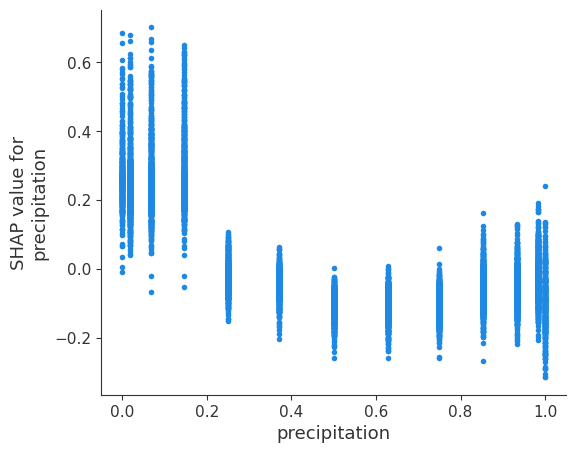

In [201]:
# Plotando dependências
shap.dependence_plot("precipitation", shap_values[1], X_test, interaction_index=None, feature_names=nomes_das_colunas)

# 5 Redução de dimensionalidade

### Resumo:
* Classificação multiclasses | A652.pickle
* Preprocessamentos: Redução de dimensionalidade com CV e discretização em 5 classes
* Mining: GradientBoostingClassifier

In [116]:
import numpy as np
import pickle
fileA652 = open('cic1205/data/atmoseer/A652.pickle' , 'rb')

### Dataset A602

In [117]:
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA652)

In [118]:
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val])

# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
# Preprocessamento (Botando as classes)
y_train[(y_train > 0) & (y_train <= 5)] = 1
y_val[(y_val > 0) & (y_val <= 5)] = 1
y_test[(y_test > 0) & (y_test <= 5)] = 1

y_train[(y_train > 5) & (y_train <= 25)] = 2
y_val[(y_val > 5) & (y_val <= 25)] = 2
y_test[(y_test > 5) & (y_test <= 25)] = 2

y_train[(y_train > 25) & (y_train <= 50)] = 3
y_val[(y_val > 25) & (y_val <= 50)] = 3
y_test[(y_test > 25) & (y_test <= 50)] = 3

y_train[y_train > 50] = 4
y_val[y_val > 50] = 4
y_test[y_test > 50] = 4

# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

### Validação cruzada usando PCA através de Variância Explicada Acumulada

In [143]:
from sklearn.decomposition import PCA
# Ajustando o range de busca
n_components_range = range(2, 23)

explained_variances = []
threshold = 0.99  # Aqui eu escolho a quantidade de variância que quero manter

for n_components in n_components_range:
    pca = PCA(n_components=n_components, random_state=0)
    pca.fit(X_train)
    
    # Calculo da variância acumulada
    cumulative_explained_variance = np.sum(pca.explained_variance_ratio_)
    explained_variances.append(cumulative_explained_variance)
    if cumulative_explained_variance > threshold:
        break

print("Explained:",explained_variances)
optimal_n_components = len(explained_variances)
print("Optimal Number of Components:", optimal_n_components)


Explained: [0.7722191549042003, 0.8685831144819872, 0.9223605398552175, 0.9587033470296499, 0.9730665241611633, 0.9820219054710371, 0.9857163544072014, 0.9890397852073598, 0.9910588041461731]
Optimal Number of Components: 9


#### Realizando treinamento do modelo

In [145]:
pca = PCA(n_components=9)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

In [147]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

# Definindo parametros
param_dist = {
    'n_estimators': [25, 50],
    'learning_rate': [0.1, 1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4, 6],
    'subsample': [0.3, 0.6, 1.0]
}

# Busca randômica
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    random_state=42
)

# Fit the randomized search to the data
random_search.fit(X_train_reduced, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_


C:\Users\miche\anaconda3\envs\ShallowLearning\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 2, 'learning_rate': 0.1}


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 2, 'learning_rate': 0.1}

In [150]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predição
y_pred = best_model.predict(X_test_reduced)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 91.22%
Confusion Matrix:
 [[8655   98   15    1    0]
 [ 660   86   11    0    0]
 [  46    4    0    0    0]
 [   3    1    0    0    0]
 [   1    1    0    0    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      8769
         1.0       0.45      0.11      0.18       757
         2.0       0.00      0.00      1.00        50
         3.0       0.00      0.00      1.00         4
         4.0       1.00      0.00      0.00         2

    accuracy                           0.91      9582
   macro avg       0.48      0.22      0.63      9582
weighted avg       0.88      0.91      0.89      9582



## Antigo resultado:

**Accuracy:** 92.86%

**Confusion Matrix:**
|     | Predicted 0 | Predicted 1 | Predicted 2 | Predicted 3 | Predicted 4 |
|-----|-------------|-------------|-------------|-------------|-------------|
| **Actual 0** | 8705        | 64          | 0           | 0           | 0           |
| **Actual 1** | 559         | 193         | 5           | 0           | 0           |
| **Actual 2** | 28          | 22          | 0           | 0           | 0           |
| **Actual 3** | 1           | 3           | 0           | 0           | 0           |
| **Actual 4** | 1           | 1           | 0           | 0           | 0           |

**Classification Report:**
|           | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| **Class 0** | 0.94      | 0.99   | 0.96     | 8769    |
| **Class 1** | 0.68      | 0.25   | 0.37     | 757     |
| **Class 2** | 0.00      | 0.00   | 1.00     | 50      |
| **Class 3** | 1.00      | 0.00   | 0.00     | 4       |
| **Class 4** | 1.00      | 0.00   | 0.00     | 2       |


#### Conclusão
- O parametro *n_components* que mantinha 99% da variância era igual a 9
- Ao treinar um previsor usando boosting com esses 9 componentes obteve-se resultados **ainda piores** que os realizados no dataset não reduzido.

# 6 Agrupamento

### Resumo:
* Classificação multiclasses | A652.pickle
* Preprocessamentos: Aplicação de K-Means e DBScan para obter rótulos (y)
* Mining: DecisionTreeClassifier
* Análise: Criar regras que expliquem os grupos gerados 

In [91]:
fileA652 = open('cic1205/data/atmoseer/A652.pickle' , 'rb')
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA652)
#Unindo dataset de treino e validação
X_train = np.concatenate([X_train, X_val], axis=0)

### K-Means

### Análise da silhueta

In [100]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np

In [101]:
for i in range(2,7):
    clusterer = KMeans(n_clusters=i, init='k-means++',random_state=0,n_init=100)
    cluster_labels = clusterer.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3078901695996887
For n_clusters = 3 The average silhouette_score is : 0.3266169141829455
For n_clusters = 4 The average silhouette_score is : 0.30069399707292693
For n_clusters = 5 The average silhouette_score is : 0.2682492747784983
For n_clusters = 6 The average silhouette_score is : 0.23870188478294607


Número ideal de clusters encontrado: 3
#### Criando o Y com os rótulos dos 3 clusters

In [94]:
rotulador = KMeans(n_clusters=3, init='k-means++',random_state=0,n_init=100)
y_test_kmeans = rotulador.fit_predict(X_test)

#### Interpretabilidade

In [95]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=3, random_state=1234)
model = clf.fit(X_test, y_test_kmeans)

In [96]:
# Ajustando as colunas
repeated_columns = np.repeat(column_names, 3) #column_names do arquivo 
nomes_das_colunas = df[repeated_columns].columns
print(nomes_das_colunas)

Index(['temperature', 'temperature', 'temperature', 'barometric_pressure',
       'barometric_pressure', 'barometric_pressure', 'relative_humidity',
       'relative_humidity', 'relative_humidity', 'wind_direction_u',
       'wind_direction_u', 'wind_direction_u', 'wind_direction_v',
       'wind_direction_v', 'wind_direction_v', 'hour_sin', 'hour_sin',
       'hour_sin', 'hour_cos', 'hour_cos', 'hour_cos', 'precipitation',
       'precipitation', 'precipitation'],
      dtype='object')


In [97]:
# Representando as regras com os nomes das colunas
text_representation = tree.export_text(clf, feature_names=nomes_das_colunas)
print(text_representation)

|--- precipitation <= 0.69
|   |--- wind_direction_v <= 0.56
|   |   |--- temperature <= 0.29
|   |   |   |--- class: 0
|   |   |--- temperature >  0.29
|   |   |   |--- class: 0
|   |--- wind_direction_v >  0.56
|   |   |--- relative_humidity <= 0.77
|   |   |   |--- class: 1
|   |   |--- relative_humidity >  0.77
|   |   |   |--- class: 0
|--- precipitation >  0.69
|   |--- relative_humidity <= 0.56
|   |   |--- temperature <= 0.17
|   |   |   |--- class: 2
|   |   |--- temperature >  0.17
|   |   |   |--- class: 0
|   |--- relative_humidity >  0.56
|   |   |--- relative_humidity <= 0.80
|   |   |   |--- class: 2
|   |   |--- relative_humidity >  0.80
|   |   |   |--- class: 0



- Percebe-se que a *precipitação* é o principal atributo de julgamento que já separa os grupos 1 e 2.
- Para separar o **grupo 1** do grupo 0 são analisadas a *direção do vento* e a *humidade relativa*.
- Para separar o **grupo 2** do grupo 0 são analisadas a *umidade relativa* e a *temperatura*.

### DBSCAN

### Análise da silhueta

In [98]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import numpy as np

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.9]
min_samples_values = [15, 30, 60, 120]

#Teste 1
#eps_values = [0.1, 0.5, 1.0]
#min_samples_values = [5, 20, 30]

#Teste 2
#eps_values = [0.8,0.9, 1.0]
#min_samples_values = [5, 10, 20]

for i in range(len(eps_values)):
    for j in range(len(min_samples_values)):
        clusterer = DBSCAN(eps=eps_values[i], min_samples=min_samples_values[j])
        cluster_labels = clusterer.fit_predict(X_train)

        # Check if there are at least two unique labels
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(X_train, cluster_labels)
            print("Ep =", eps_values[i], " Min_samples =", min_samples_values[j], " The average silhouette_score is :", silhouette_avg)
        else:
            print("Ep =", eps_values[i], " Min_samples =", min_samples_values[j], " Unable to calculate silhouette_score with only one label.")


Ep = 0.9  Min_samples = 15  The average silhouette_score is : 0.2816204637865667
Ep = 0.9  Min_samples = 30  The average silhouette_score is : 0.2941724616226092
Ep = 0.9  Min_samples = 60  The average silhouette_score is : 0.2947187999487891
Ep = 0.9  Min_samples = 120  The average silhouette_score is : 0.2947187999487891


- Melhor resultado do primeiro teste:  Ep = 1.0
- Melhor resultado do segundo teste: Ep = 0.9 __ Min_samples = 20
- Melhor resultado do segundo teste: Ep = 0.9 __ Min_samples = 30

Melhor resultado: 
- Ep = 0.9
- Min_samples = 30
- The average silhouette_score is : 0.2941724616226092

#### Criando o Y com os rótulos do DBSCAN

In [109]:
rotulador = DBSCAN(eps=0.9, min_samples=30)
y_test_dbscan = rotulador.fit_predict(X_test)

#### Interpretabilidade

In [110]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=3, random_state=1234)
model = clf.fit(X_test, y_test_dbscan)

In [111]:
# Ajustando as colunas
repeated_columns = np.repeat(column_names, 3) #column_names do arquivo 
nomes_das_colunas = df[repeated_columns].columns
print(nomes_das_colunas)

Index(['temperature', 'temperature', 'temperature', 'barometric_pressure',
       'barometric_pressure', 'barometric_pressure', 'relative_humidity',
       'relative_humidity', 'relative_humidity', 'wind_direction_u',
       'wind_direction_u', 'wind_direction_u', 'wind_direction_v',
       'wind_direction_v', 'wind_direction_v', 'hour_sin', 'hour_sin',
       'hour_sin', 'hour_cos', 'hour_cos', 'hour_cos', 'precipitation',
       'precipitation', 'precipitation'],
      dtype='object')


In [112]:
# Representando as regras com os nomes das colunas
text_representation = tree.export_text(clf, feature_names=nomes_das_colunas)
print(text_representation)

|--- hour_sin <= 0.75
|   |--- class: 0
|--- hour_sin >  0.75
|   |--- hour_sin <= 0.97
|   |   |--- class: -1
|   |--- hour_sin >  0.97
|   |   |--- class: 0



- Percebe-se que *hour_sin* foi o único atributo utilizado para a separação de duas classes.
- Dependendo da variação deste atributo no tempo (3 observações da janela temporal) as classes foram extraidas